# Auto MPG

# NJIT

John Morrison  
Joseph Bennett

## Introduction

The goal of this project is to estimate the miles per gallon (mpg) of the different types of cars given a set of other attributes of the car, for example, the number of cylinders in the engine, the weight of the car, the model year, etc...

* The data set is maintained by Carniege Mellon and can be downloaded from [UCI Machine Learning](https://archive.ics.uci.edu/ml/datasets/auto+mpg).
* The methods for generating the models were found at [SciLearn](https://scikit-learn.org/stable/modules/linear_model.html).
* The rationale for using Kernel Ridge Regression was found from [SciLearn: Kernel Ridge Regression](https://scikit-learn.org/stable/modules/kernel_ridge.html#kernel-ridge-regression).

We want to predict a numerical value for the miles per gallon (mpg) therefore the models we use will be linear and non-linear regression models:
1. Ordinary Least Squares model (linear),
2. Kernel Ridge Regression model (non-linear),
3. Support Vector Regression model (linear, and two non-linear kernels).  

We use the `GridSearchCV` function to determine the most optimal parameter sets to run each of the models. Then use the results to build our model using the data now split into a training and testing set. Because these are regression models, we use `R-squared` and `Mean Squared Error` to determine model performance. 

## Necessary Libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt

## Read the Dataset

In [35]:
data = pd.read_csv('auto-mpg.data', sep='\s+')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## Data Preprocessing

The data is not clean. Some of the values of horsepower are not known and marked with '?' to indicate this.

In [36]:
data.where(data['horsepower'] == '?').dropna()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
32,25.0,4.0,98.0,?,2046.0,19.0,71.0,1.0,ford pinto
126,21.0,6.0,200.0,?,2875.0,17.0,74.0,1.0,ford maverick
330,40.9,4.0,85.0,?,1835.0,17.3,80.0,2.0,renault lecar deluxe
336,23.6,4.0,140.0,?,2905.0,14.3,80.0,1.0,ford mustang cobra
354,34.5,4.0,100.0,?,2320.0,15.8,81.0,2.0,renault 18i
374,23.0,4.0,151.0,?,3035.0,20.5,82.0,1.0,amc concord dl


In [37]:
data.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

We will drop this data because the horsepower variable is important in determining the mpg target variable. We will also need to convert the horsepower variable to a numeric type becuase, when it was loaded it was automatically converted to an 'object' type.

In [38]:
data = data[data['horsepower'] != '?']
data['horsepower'] = pd.to_numeric(data['horsepower'])

In [39]:
data.shape

(392, 9)

In [40]:
data.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

Drop the car name, this is not used in the regression analysis.

In [41]:
data = data.drop(['car_name'], axis=1)

### Train Test Split and Cross Validation

We split the data into two forms. The first form is used for cross validation of various models using sklearn's `GridSearchCV` function in order to determine the best parameters to use.

In [42]:
cross_X = data.drop(['mpg'], axis=1)
cross_y = pd.DataFrame(data, columns=['mpg'])

The next data set below, is used to train the selected model and test before deployment.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['mpg'], axis=1), pd.DataFrame(data, columns=['mpg']), 
    test_size=0.10, random_state=42)

### Data Normalization

In [44]:
min_train = X_train.min(axis=0)
max_train = X_train.max(axis=0)

range_train = (X_train - min_train).max(axis=0)
range_train_new = max_train-min_train

X_train_scaled = (X_train - min_train)/range_train
X_test_scaled = (X_test - min_train)/range_train
print(X_train_scaled.head())
transformer = Normalizer().fit(X_train)
transformer.transform(X_train)

     cylinders  displacement  horsepower    weight  acceleration  model_year  \
73         1.0      0.615584    0.456522  0.704565      0.357143    0.166667   
147        0.2      0.051948    0.157609  0.140346      0.446429    0.333333   
375        0.2      0.090909    0.152174  0.104054      0.434524    1.000000   
143        0.2      0.070130    0.173913  0.194783      0.386905    0.333333   
159        1.0      0.729870    0.554348  0.863056      0.327381    0.416667   

     origin  
73      0.0  
147     0.5  
375     0.5  
143     0.5  
159     0.0  


array([[ 0.00194543,  0.07465588,  0.03161324, ...,  0.0034045 ,
         0.01750887,  0.00024318],
       [ 0.00189339,  0.04260131,  0.03550109, ...,  0.00733689,
         0.03502775,  0.0009467 ],
       [ 0.00201418,  0.05287221,  0.03726232, ...,  0.00770424,
         0.04129068,  0.00100709],
       ..., 
       [ 0.00139793,  0.05277185,  0.02970601, ...,  0.00615089,
         0.02725963,  0.00034948],
       [ 0.00167759,  0.04110095,  0.02726083, ...,  0.00868153,
         0.03397119,  0.0004194 ],
       [ 0.00159496,  0.07974824,  0.02990559, ...,  0.00279119,
         0.01455405,  0.00019937]])

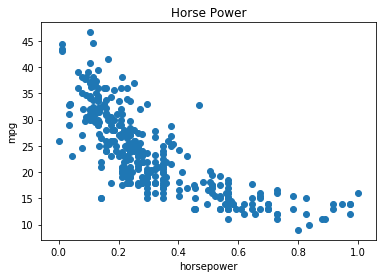

In [45]:
plt.scatter(X_train_scaled['horsepower'],y_train)
plt.title('Horse Power')
plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.show()

### Independent 

In [46]:
X_train_scaled.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
73,1.0,0.615584,0.456522,0.704565,0.357143,0.166667,0.0
147,0.2,0.051948,0.157609,0.140346,0.446429,0.333333,0.5
375,0.2,0.090909,0.152174,0.104054,0.434524,1.000000,0.5
143,0.2,0.070130,0.173913,0.194783,0.386905,0.333333,0.5
159,1.0,0.729870,0.554348,0.863056,0.327381,0.416667,0.0


### Target

In [47]:
y_train.head()

,mpg
73,13.0
147,24.0
375,36.0
143,26.0
159,14.0


## Building the Models

#### Selected Models
1. Ordinary Least Squares
2. Ridge Regression
3. Lasso
4. Support Vector Regression

### Ordinary Least Squares

According to [Skilearn](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares), Ordinary Least Squares will attempt to fit a linear model that will minimize the residual sum of squares between the observed responses in the dataset, and the responses predicted by the linear approximation.



We will build a series of k=5 cross validation models to find the most optimal parameters.

In [48]:
model = LinearRegression()
parameters = {'fit_intercept':[True, False],
              'normalize':[True, False],
              'copy_X':[True,False]}
grid_ols = GridSearchCV(model, parameters, cv=5, scoring="r2", iid=False)
grid_ols.fit(cross_X, cross_y)
print ("r2 / variance: {0:.3f}".format(grid_ols.best_score_))
print ("Best Parameter set: {}".format(grid_ols.best_params_))

r2 / variance: 0.620
Best Parameter set: {'fit_intercept': False, 'copy_X': True, 'normalize': True}


Using the parameter set found above build the model that we will compare with the other models types.

In [49]:
ols = LinearRegression(**grid_ols.best_params_)
ols.fit(X_train_scaled, y_train.values.ravel())
ols_pred_train = ols.predict(X_train_scaled)
ols_pred_test = ols.predict(X_test_scaled)
print ("Coeffiecents: {}".format(ols.coef_))
print ("r2 /variance for test: {0:.4f}".format(r2_score(y_test, ols_pred_test)))
print ("Mean Squared Error: {:.3f}".format(mean_squared_error(y_test, ols_pred_test)))
print ("Residual sum of squares training set: {0:.4f}".format(np.mean((ols_pred_train-y_train.values.ravel())**2)))
print ("Residual sum of squares testing set: {0:.4f}".format(np.mean((ols_pred_test-y_test.values.ravel())**2)))

Coeffiecents: [  4.10158875   2.99158397  33.81626466 -37.08598689  32.43288018
  14.84307694   5.59497003]
r2 /variance for test: 0.5939
Mean Squared Error: 24.162
Residual sum of squares training set: 25.3397
Residual sum of squares testing set: 24.1624


#### Residual Plot

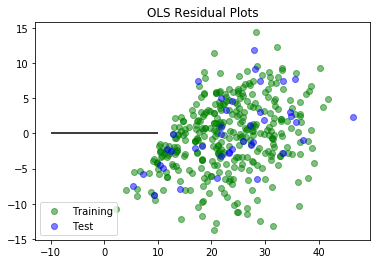

In [50]:
train = plt.scatter(ols_pred_train,(ols_pred_train-y_train.values.ravel()),c='g',alpha=0.5)
test = plt.scatter(ols_pred_test,(ols_pred_test-y_test.values.ravel()),c='b',alpha=0.5)
plt.hlines(y=0, xmin=-10,xmax=10)
plt.legend((train,test),('Training','Test'),loc='lower left')
plt.title('OLS Residual Plots')
plt.show()

Plot Analysis - as you can see the residual plot has some shape to it which can indicate that a linear model might not be appropriate. This could describe why the rbf kernel proved to be the best parameter for the Support Vector Regression, which is found further down in the notebook.

### Kernel Ridge Regression

According to [SciLearn](https://scikit-learn.org/stable/modules/kernel_ridge.html#kernel-ridge-regression), Kernel Ridge Regression is a method that combines Ridge Regression with the same kernel trick used by SVR to learn a non-linear function that best fits the data. The two methods differ in the loss function (ridge versus epslion-insensitive loss). KRR is usually faster that

Accuracy scores for a k=5 Cross validation for a Ridge Regression Linear Model

In [51]:
model = KernelRidge()
parameters = {
    'alpha': [.001, .01, .1, 1.0],
    'gamma': np.logspace(-2, 2, 5)}
grid_ridge = GridSearchCV(model, parameters, cv=5, scoring="r2", iid=False)
grid_ridge.fit(cross_X, cross_y)
print ("r2 / variance: {0:.4f}".format(grid_ridge.best_score_))
print ("Best Parameter set: {}".format(grid_ridge.best_params_))

r2 / variance: 0.6204
Best Parameter set: {'gamma': 0.01, 'alpha': 0.001}


In [52]:
ridge = KernelRidge(**grid_ridge.best_params_)
ridge.fit(X_train_scaled, y_train.values.ravel())
ridge_pred_train = ols.predict(X_train_scaled)
ridge_pred_test = ols.predict(X_test_scaled)
print ("r2 /variance for test: {0:.4f}".format(r2_score(y_test, ridge_pred_test)))
print ("Mean Squared Error: {:.3f}".format(mean_squared_error(y_test, ridge_pred_test)))
print ("Residual sum of squares training set: {0:.4f}".format(np.mean((ridge_pred_train-y_train.values.ravel())**2)))
print ("Residual sum of squares testing set: {0:.4f}".format(np.mean((ridge_pred_test-y_test.values.ravel())**2)))

r2 /variance for test: 0.5939
Mean Squared Error: 24.162
Residual sum of squares training set: 25.3397
Residual sum of squares testing set: 24.1624


### Support Vector Regression

Accoriding to [Scikit-learn](https://scikit-learn.org/stable/modules/svm.html#svm-regression), Support Vector Classification can be extended to regression as well. We ran the various types of SVR models: linear, rbf, and poly. 

In [53]:
svm_lin = SVR(kernel='linear', C=1000)
svm_lin.fit(X_train_scaled, y_train.values.ravel())
svm_lin_pred_test = svm_lin.predict(X_test_scaled)
print("r2 / variance for test: {0:.3f}".format(r2_score(y_test, svm_lin_pred_test)))
print ("Mean Squared Error: {:.3f}".format(mean_squared_error(y_test, svm_lin_pred_test)))

r2 / variance for test: 0.835
Mean Squared Error: 9.806


In [54]:
svm_rbf = SVR(kernel='rbf', C=1000, gamma='auto')
svm_rbf.fit(X_train_scaled, y_train.values.ravel())
svm_rbf_pred_test = svm_rbf.predict(X_test_scaled)
print("r2 / variance for test: {0:.3f}".format(r2_score(y_test, svm_rbf_pred_test)))
print ("Mean Squared Error: {:.3f}".format(mean_squared_error(y_test, svm_rbf_pred_test)))

r2 / variance for test: 0.936
Mean Squared Error: 3.787


In [55]:
svm_poly = SVR(kernel='poly', C=1000, gamma='auto')
svm_poly.fit(X_train_scaled, y_train.values.ravel())
svm_poly_pred_test = svm_poly.predict(X_test_scaled)
print("r2 / variance for test: {0:.3f}".format(r2_score(y_test, svm_poly_pred_test)))
print ("Mean Squared Error: {:.3f}".format(mean_squared_error(y_test, svm_poly_pred_test)))

r2 / variance for test: 0.915
Mean Squared Error: 5.035


#### SVR Grid Search:
Rather than running each model instance indivually, you can use grid search to perform a cross-validation of the different parameters. Keep in mind this process can take a while as it is doing every combination of the parameters.

In [56]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'gamma':['auto'], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma':['auto'], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000], 'gamma':['auto'], 'kernel': ['poly']},
 ]

In [57]:
svr = GridSearchCV(SVR(C=1),param_grid, cv=5)
svr.fit(X_train_scaled, y_train.values.ravel())
print('Best Model: %s' % svr.best_params_)

Best Model: {'gamma': 'auto', 'kernel': 'rbf', 'C': 1000}


## Conclusion

Given the evidence above, we would use the SVR model with the RBF kernel. It produced around 93% accuracy. We used Grid Search to tune our hyper parameters. The Grid Search returns the best model which is conveinent. For instance a user could run the predict method if they wanted to test the model on different data ie. svr.predict(some new x data). Another popular cross validation tool is Randomized Search.

In conclusion we used a Support Vector based model, performed data visualization, and used Cross-Validation to tune hyper parameters. 

## Resources

https://scikit-learn.org

https://archive.ics.uci.edu/ml/datasets/auto+mpg
